In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline

In [3]:
path = 'kaggle_titanic\\train.csv'
path_test = 'kaggle_titanic\\test.csv'
train_data = pd.read_csv(path)
test_data = pd.read_csv(path_test)

In [4]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# geting datatypes
train_data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [6]:
# Filling mean Age instead Nan
train_data['Age'].fillna(round(train_data['Age'].mean()), inplace=True)
test_data['Age'].fillna(round(train_data['Age'].mean()), inplace=True)

In [7]:
# Creating 'One Hot Encoding' columns
train_data[['Female', 'Male']] = pd.get_dummies(train_data['Sex'])
train_data[['Embarked_C', 'Embarked_Q', 'Embarked_S']] = pd.get_dummies(train_data['Embarked'])

test_data[['Female', 'Male']] = pd.get_dummies(train_data['Sex'])
test_data[['Embarked_C', 'Embarked_Q', 'Embarked_S']] = pd.get_dummies(train_data['Embarked'])

In [8]:
# Creating new column: % from Fare.mean()
train_data['Fare_avg'] = round((train_data['Fare'] / train_data.Fare.mean() * 100))
test_data['Fare_avg'] = round((train_data['Fare'] / train_data.Fare.mean() * 100))

In [9]:
# check survive by gender
women = train_data.loc[train_data.Sex == 'female']["Survived"]
rate_women = sum(women)/len(women)
print("% of women who survived:", rate_women)

men = train_data.loc[train_data.Sex == 'male']["Survived"]
rate_men = sum(men)/len(men)
print("% of men who survived:", rate_men)

% of women who survived: 0.7420382165605095
% of men who survived: 0.18890814558058924


In [10]:
# Preparation data for model
features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Female', 'Male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Fare_avg']
y = train_data['Survived']
X = train_data[features]

X_test_final = test_data[features]


### Splitting train_data in train/test chunks for checking myself


In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, det_curve

In [189]:
# Function for checking & compare models
'''
 Final metrics choosed: 
    1. Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores;
    2. Compute the F1 score, also known as balanced F-score or F-measure.
'''    
model_score_dict = {} # container for all models scores
def try_model(model):
    # Training
    model.fit(X_train, y_train)  
    # Checking
    y_pred = model.predict(X_test)
    # Fill container to compare y_pred & y_test
    model_score_dict[str(model)[:35]] = [roc_auc_score(y_pred, y_test), f1_score(y_pred, y_test)]

In [190]:
# Import different models to check
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, \
                             GradientBoostingClassifier, BaggingClassifier
from sklearn.linear_model import RidgeClassifier

In [191]:
ridge_model = RidgeClassifier()
try_model(ridge_model)

In [192]:
rfc_model1 = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
try_model(rfc_model1)

In [193]:
rfc_model2 = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=1)
try_model(rfc_model2)

In [194]:
gbc_model = GradientBoostingClassifier(n_estimators=150, max_depth=3, random_state=0)
try_model(gbc_model)

In [195]:
abc_m = AdaBoostClassifier()
try_model(abc_m)

In [196]:
etc_model = ExtraTreesClassifier()
try_model(etc_model)

In [197]:
bag_c_model = BaggingClassifier()
try_model(bag_c_model)

In [198]:
from sklearn.ensemble import StackingClassifier
best_estimators = [('rfc2', RandomForestClassifier(n_estimators=100, max_depth=15, random_state=1)),(
                'gbc', GradientBoostingClassifier(n_estimators=150, max_depth=3, random_state=0)),(
                'adab', AdaBoostClassifier())]

stc_model = StackingClassifier(estimators = best_estimators, final_estimator = None)
try_model(stc_model)

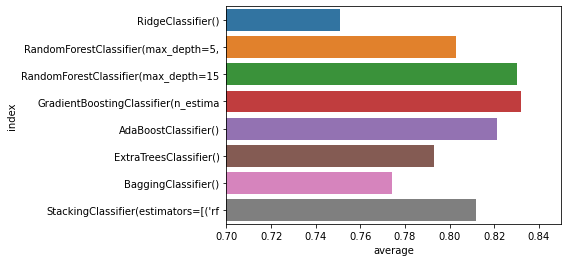

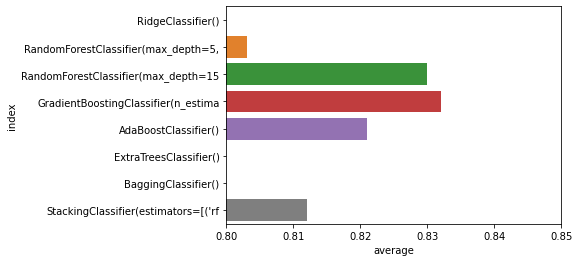

In [199]:
model_df = pd.DataFrame(model_score_dict)
model_df = model_df.T
model_df.columns = ['roc_auc_score', 'f1_score']
model_df['average'] = round((model_df['roc_auc_score'] + model_df['f1_score']) / 2, 3)
sns.barplot(data=model_df.reset_index(), x="average", y='index')
plt.xlim(0.7, 0.85)
plt.show()
sns.barplot(data=model_df.reset_index(), x="average", y='index')
plt.xlim(0.8, 0.85)
plt.show()

In [203]:
# training best model on all train_data
final_model = GradientBoostingClassifier(n_estimators=150, max_depth=3, random_state=0)
final_model.fit(X, y)
final_model.score(X, y)


0.9090909090909091

In [204]:

predictions = final_model.predict(X_test_final)

In [205]:


output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
